# And

Bloqs for doing "AND" logical operations.

The behavior is modified by the 'control variable' attributes. A traditional value of '1'
means that a bit value of '1' is logical true for the and operation. A control value of
'0' means that a bit value of '0' is the logical true.

The `Toffoli` bloq is similar to the `And` bloq. Toffoli will flip the target bit according
to the and of its control registers. `And` will output the result into a fresh register.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `And`
A two-bit 'and' operation optimized for T-count.

#### Parameters
 - `cv1`: Whether the first bit is a positive control.
 - `cv2`: Whether the second bit is a positive control. 

#### Registers
 - `ctrl`: A two-bit control register.
 - `target [right]`: The output bit. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).     Babbush et al. 2018. Section III.A. and Fig. 4.
 - [Verifying Measurement Based Uncomputation](https://algassert.com/post/1903). Gidney, C. 2019.


In [2]:
from qualtran.bloqs.mcmt import And

### Example Instances

In [3]:
and_bloq = And()

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([and_bloq],
           ['`and_bloq`'])

### Call Graph

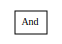

#### Counts totals:
 - `And`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
and_bloq_g, and_bloq_sigma = and_bloq.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(and_bloq_g)
show_counts_sigma(and_bloq_sigma)

### Clifford + T implementation

`And` will be considered an Atomic (non-decomposable) bloq within the Qualtran standard library. An additional method is provided to assist in fully compiling to a Clifford+T gateset.

In [6]:
and_bloq.to_clifford_t_circuit()

ctrl_0: ───────────@───────X───T^-1──────────X───────────────
                   │       │                 │
ctrl_1: ───────────┼───@───┼───X──────T^-1───┼───X───────────
                   │   │   │   │             │   │
target: ───H───T───X───X───@───@──────T──────@───@───H───S───

In [7]:
and_bloq.adjoint().to_clifford_t_circuit()

┌──┐
ctrl_0: ────────────@─────
                    ║
ctrl_1: ────────────@─────
                    ║
target: ───H───M────╫R────
               ║    ║
target: ═══════@════^═════
                   └──┘

## `MultiAnd`
A many-bit (multi-control) 'and' operation.

#### Parameters
 - `cvs`: A tuple of control variable settings. Each entry specifies whether that control line is a "positive" control (`cv[i]=1`) or a "negative" control `0`. If a HasLength object is passed, assumes the control values to be all 1's.  

#### Registers
 - `ctrl`: An n-bit control register.
 - `junk [right]`: An `n-2` bit junk register to be cleaned up by the inverse operation.
 - `target [right]`: The output bit.


In [8]:
from qualtran.bloqs.mcmt import MultiAnd

### Example Instances

In [9]:
multi_and = MultiAnd(cvs=(1, 0, 1, 0, 1, 0))

#### Graphical Signature

In [10]:
from qualtran.drawing import show_bloqs
show_bloqs([multi_and],
           ['`multi_and`'])

### Call Graph

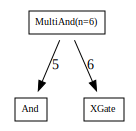

#### Counts totals:
 - `And`: 5
 - `XGate`: 6

In [11]:
from qualtran.resource_counting.generalizers import ignore_split_join
multi_and_g, multi_and_sigma = multi_and.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(multi_and_g)
show_counts_sigma(multi_and_sigma)

## Additional Demos

### Testing with states and effects

We can use `ZeroState` and its friends to test the truth table on this classical logic.

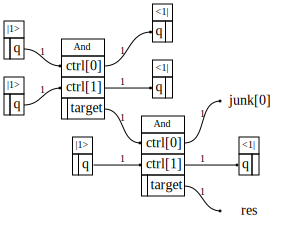

In [12]:
from qualtran.bloqs.basic_gates import OneEffect, OneState, ZeroEffect, ZeroState

state = [ZeroState(), OneState()]
eff = [ZeroEffect(), OneEffect()]

# Experiment with changing the following:
cvs = (1, 1, 1)
ctrl_string = (1, 1, 1)


bb = BloqBuilder()
ctrl_qs = [bb.add(state[c]) for c in ctrl_string]
ctrl_qs, junk, res = bb.add_from(MultiAnd(cvs), ctrl=ctrl_qs)
for c, q in zip(ctrl_string, ctrl_qs):
    bb.add(eff[c], q=q)

cbloq = bb.finalize(junk=junk, res=res)
show_bloq(cbloq)

In [13]:
# Our tensor network now just has the result index and a junk index.
# We use `np.where` to find non-zero entries into this.
# In fact -- the second index corresponding to `res` is the bit output
vec = cbloq.tensor_contract()
junk_i, res_i = np.where(vec.reshape((2, 2)))
res_i

/usr/local/google/home/mpharrigan/qualtran/conda-311/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/usr/local/google/home/mpharrigan/qualtran/conda-311/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


array([1])

In [14]:
# The truthiness of the non-zero res index should match the desired logical function.
should_be = np.all(ctrl_string == cvs)
should_be

True

### Classical Simulation

The `And` gate is classical logic, so we can simulate it on discrete bitstrings.

In [15]:
ctrl, out = And().call_classically(ctrl=np.array([1, 1]))
out

1

In [16]:
ctrl = np.array([1,1,1,1])
ctrl, junk, out = MultiAnd((1,1,1,1)).call_classically(ctrl=ctrl)
out

1

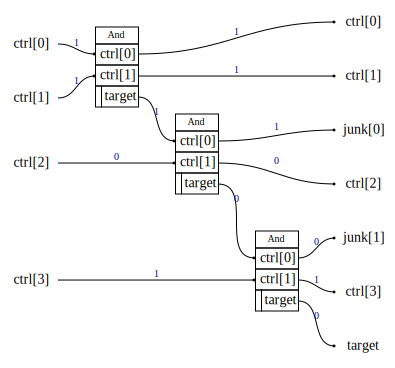

In [17]:
from qualtran.drawing import ClassicalSimGraphDrawer

ClassicalSimGraphDrawer(
    MultiAnd((1,1,1,1)).decompose_bloq(), 
    vals=dict(ctrl=[1,1,0,1])
).get_svg()